In [79]:
import pandas as pd
import numpy as np

In [91]:
df_rumc = pd.read_pickle('../data/processed/rumc.pkl')
df_ictcf = pd.read_pickle('../data/processed/ictcf.pkl')

In [92]:
input_features = df_rumc.columns[~df_rumc.columns.isin(['pcr', 'corads', 'part', 'diagnosis']) & ~df_rumc.columns.str.startswith('vis_')]
df_rumc = df_rumc[input_features]
df_rumc[df_rumc == 'nan'] = np.nan
df_rumc[df_rumc == 'Missing'] = np.nan
df_rumc[df_rumc == 'missing'] = np.nan

In [53]:
def aggregate_features(df: pd.DataFrame) -> pd.DataFrame:
    # import re
    from pandas.api.types import is_numeric_dtype
    # df = df.rename(columns=lambda x: re.sub('[^-()%A-Za-z0-9_/ ]+', '', x))
    # df.columns = df.columns.str.replace(' ', '_')

    df_merged = df.copy()
    df_merged.columns = df.columns.str.replace(r'\(.+?\)', '', regex=True).str.strip()

    def aggregate(x: pd.Series):
        if x.shape[1] == 1:
            return x.iloc[:, 0]
        if is_numeric_dtype(x.dtypes[0]):
            return x.mean(axis=1)
        result = x.apply(lambda y: next(z for z in y.values if not pd.isna(z)) if not y.isna().all() else np.nan,
                         axis=1)
        return result

    df = df_merged.groupby(df_merged.columns, axis=1).agg(aggregate)

    # input_features = features.input_features
    input_features = df.columns[~df.columns.isin(['pcr', 'corads', 'part', 'diagnosis'])]

    # df[df == 'nan'] = np.nan
    # for col in input_features:
    #     if not is_numeric_dtype(df[col]):
    #         df[col] = df[col].astype('category')
    #         df[col] = df[col].cat.codes.astype('category')

    for col in df.columns:
        try:
            df[col] = pd.to_numeric(df[col], errors='raise')
        except ValueError:
            df[col] = df[col].astype('category')
            # num_cats = df_pivot[col].cat.categories[df_pivot[col].cat.categories.str.match(r'\d+', na=False)]
            # df_pivot[col].cat.rename_categories({cat: 'v' + cat for cat in num_cats}, inplace=True)
#             df[col].cat.add_categories(['Missing'], inplace=True)
#             df[col].fillna('Missing', inplace=True)
    return df

In [54]:
df_rumc_aggr = aggregate_features(df_rumc)

In [55]:
df_rumc.columns[df_rumc.columns.str.lower().str.contains('bacterien')]

Index(['bacterien (urine)'], dtype='object')

In [57]:
df_rumc_aggr['bacterien']

patientprimarymrn  study
10000              st000    Positief
                   st001    Positief
10001              st000         NaN
10002              st000         NaN
10003              st000         NaN
                              ...   
10723              st000         NaN
10724              st000         NaN
10725              st000         NaN
10726              st000         NaN
10727              st000         NaN
Name: bacterien, Length: 814, dtype: category
Categories (3, object): ['Positief', 'nan', 'Missing']

In [58]:
df_rumc_aggr.columns[df_rumc_aggr.isna().mean() <= 0.05]

Index([], dtype='object')

In [93]:
categorical_features = ["Metadata_Sex"] + [col for col in df_ictcf.columns if col.startswith("Disease_")]
numeric_features = [col for col in df_ictcf.columns if col.startswith("Value_")] + ['Metadata_Age',
                                                                              'Metadata_Temperature']
df_ictcf_pcr = df_ictcf['Metadata_PCR']
df_ictcf = df_ictcf[categorical_features + numeric_features]


In [60]:
df_rumc.isna().sum().sum() / np.prod(df_rumc.shape) * 100

93.6856282258165

In [61]:
df_rumc_aggr.isna().sum().sum() / np.prod(df_rumc.shape) * 100

77.46567580021599

In [62]:
df_ictcf.isna().sum().sum() / np.prod(df_ictcf.shape) * 100

57.596819135280676

<AxesSubplot:ylabel='patientprimarymrn-study'>

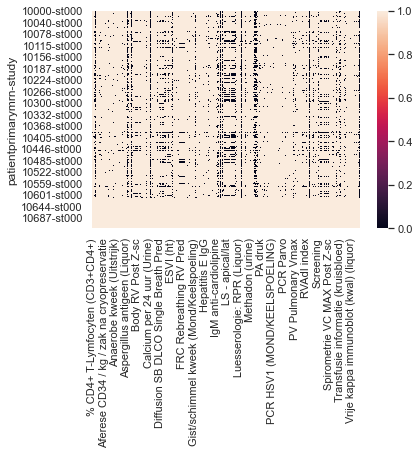

In [63]:
import seaborn as sns
sns.heatmap(df_rumc.isna())

<AxesSubplot:ylabel='patientprimarymrn-study'>

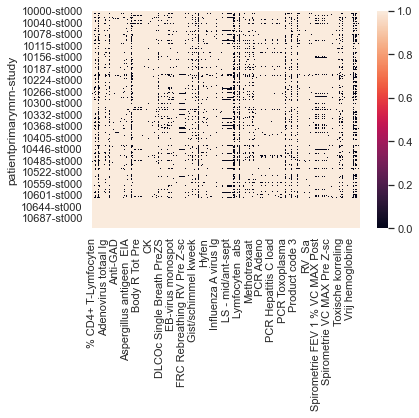

In [136]:
import seaborn as sns
sns.heatmap(df_rumc_aggr.isna())

<AxesSubplot:>

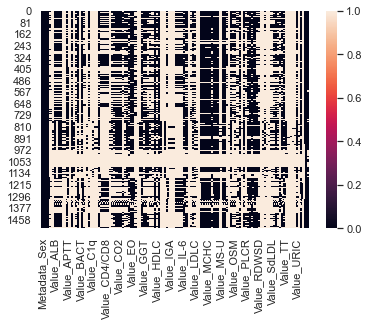

In [65]:
sns.heatmap(df_ictcf.isna())

In [94]:
pd.concat([df_ictcf.isna(), df_ictcf_pcr], axis=1)

,Metadata_Sex,Disease_hypertension,Disease_diabetes,Disease_coronary atherosclerotic heart disease,Value_5NT,Value_AFU,Value_ALB,Value_ALG,Value_ALP,Value_ALT,...,Value_UNCC,Value_UNCX,Value_URBC,Value_URIC,Value_UWBC,Value_WBC,Value_WBCC,Metadata_Age,Metadata_Temperature,Metadata_PCR
0,False,False,False,False,False,True,False,False,False,False,...,True,True,True,False,True,False,True,False,False,Positive
1,False,False,False,False,False,True,False,False,False,False,...,True,True,True,False,True,False,True,False,False,Positive
2,False,False,False,False,True,True,False,False,False,False,...,True,True,True,False,True,False,True,False,False,Positive
3,False,False,False,False,False,True,False,False,False,False,...,True,True,True,False,True,False,True,False,False,Positive
4,False,False,False,False,True,True,True,True,True,True,...,True,True,True,True,True,False,True,False,False,Positive
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1516,False,False,False,False,False,True,False,False,False,False,...,True,True,True,False,True,False,True,False,False,Positive
1517,False,False,False,False,True,True,True,True,True,True,...,True,True,True,True,True,False,True,False,False,Positive
1518,False,False,False,False,True,True,True,True,True,True,...,True,True,True,True,True,False,True,False,False,Positive
1519,False,False,False,False,True,True,True,True,True,True,...,True,True,True,True,True,False,True,False,False,Positive


In [106]:
pcr_isna

,Metadata_Sex,Disease_hypertension,Disease_diabetes,Disease_coronary atherosclerotic heart disease,Value_5NT,Value_AFU,Value_ALB,Value_ALG,Value_ALP,Value_ALT,...,Value_UALB,Value_UNCC,Value_UNCX,Value_URBC,Value_URIC,Value_UWBC,Value_WBC,Value_WBCC,Metadata_Age,Metadata_Temperature
Metadata_PCR,,,,,,,,,,,,,,,,,,,,,
Negative,0.0,0.0,0.0,0.0,0.859375,0.897569,0.286458,0.536458,0.286458,0.286458,...,0.986111,0.991319,0.979167,0.951389,0.279514,0.951389,0.159722,0.991319,0.0,0.168403
Positive,0.0,0.0,0.0,0.0,0.860317,0.954497,0.429630,0.556614,0.430688,0.430688,...,0.998942,0.993651,0.982011,0.968254,0.431746,0.964021,0.159788,1.000000,0.0,0.058201


In [133]:
most_different = np.abs(pcr_isna.loc['Positive'] - pcr_isna.loc['Negative']).sort_values(ascending=False)[:16]

In [128]:
import pickle
with open('../data/processed/mapping.pkl', 'rb') as f:
    mapping = pickle.load(f)

In [134]:
[(mapping[k], np.round(v, decimals=3)) for k, v in most_different.items()]

[('CD3+ T cell Value', 0.383),
 ('CD8+ T cell Value', 0.383),
 ('CD4/CD8 ratio Value', 0.383),
 ('CD4+ T cell Value', 0.383),
 ('Interleukin-10 Value', 0.382),
 ('Interleukin-4 Value', 0.382),
 ('Interleukin-2 Value', 0.382),
 ('IFN-γ Value', 0.382),
 ('Interleukin-6 Value', 0.382),
 ('TNF-α Value', 0.382),
 ('Standard deviation of red cell volume distribution width Value', 0.254),
 ('B lymphocyte Value', 0.238),
 ('Natural killer cell Value', 0.238),
 ('Coefficient variation of red cell volume distribution width Value', 0.201),
 ('Erythrocyte sedimentation rate Value', 0.189),
 ('Glucose Value', 0.182)]

In [135]:
df_rumc.columns[df_rumc.columns.str.contains('Glucose')]

Index(['Glucose', 'Glucose (Liquor)', 'Glucose (POCT)', 'Glucose (bloedgas)',
       'Glucose (overig)', 'Glucose (urine)', 'Glucose T1',
       'Glucose T1 (Bloedgas)', 'Glucose T2', 'Glucose T3', 'Glucose T4',
       'Glucose kwal. (Urine)', 'Glucose ratio liquor/bloed'],
      dtype='object')

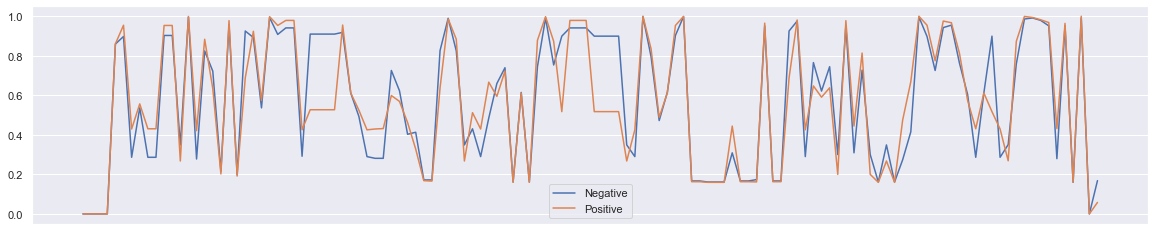

In [115]:
pcr_isna = pd.concat([df_ictcf.isna(), df_ictcf_pcr], axis=1).groupby('Metadata_PCR').mean()
plt.figure(figsize=(20, 4))
plt.plot(pcr_isna.iloc[0, :], label='Negative')
plt.plot(pcr_isna.iloc[1, :], label='Positive')
plt.legend()
plt.xticks([]);

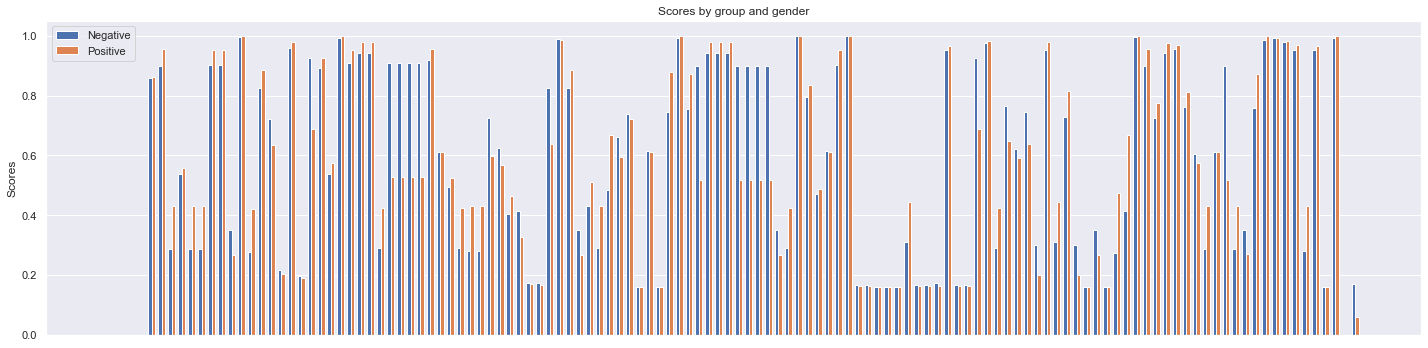

In [114]:
x = np.arange(len(pcr_isna.columns))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots(figsize=(20, 5))
rects1 = ax.bar(x - width/2, pcr_isna.iloc[0, :], width, label='Negative')
rects2 = ax.bar(x + width/2, pcr_isna.iloc[1, :], width, label='Positive')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Scores')
ax.set_title('Scores by group and gender')
ax.set_xticks([])
ax.legend()

fig.tight_layout()

plt.show()

In [66]:
(~df_rumc.isna()).sum(axis=1).median()

74.5

In [67]:
(~df_ictcf.isna()).sum(axis=1).median()

57.0

In [68]:
((~df_rumc.isna()).mean() > 0.7).sum()

0

In [69]:
((~df_ictcf.isna()).mean() > 0.9).sum()

6

In [70]:
import matplotlib.pyplot as plt
xs = np.linspace(0.2, 1, 100)
y_rumc = [((~df_rumc.isna()).mean() > x).sum() for x in xs]
y_rumc_aggr = [((~df_rumc_aggr.isna()).mean() > x).sum() for x in xs]
y_ictcf = [((~df_ictcf.isna()).mean() > x).sum() for x in xs]

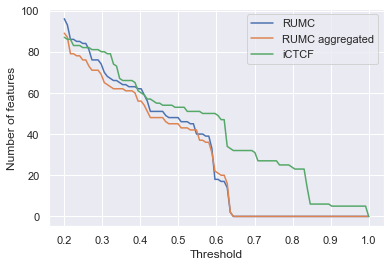

In [71]:
sns.set()
plt.plot(xs, y_rumc, label='RUMC')
plt.plot(xs, y_rumc_aggr, label='RUMC aggregated')
plt.plot(xs, y_ictcf, label='iCTCF')
plt.xlabel('Threshold')
plt.ylabel('Number of features')
plt.legend()

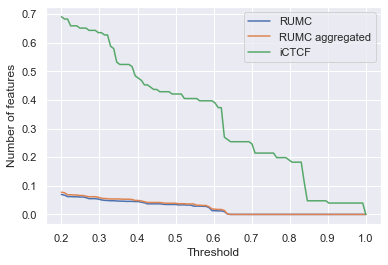

In [73]:
sns.set()
plt.plot(xs, np.array(y_rumc)/len(df_rumc.columns), label='RUMC')
plt.plot(xs, np.array(y_rumc_aggr)/len(df_rumc_aggr.columns), label='RUMC aggregated')
plt.plot(xs, np.array(y_ictcf)/len(df_ictcf.columns), label='iCTCF')
plt.xlabel('Threshold')
plt.ylabel('Number of features')
plt.legend()

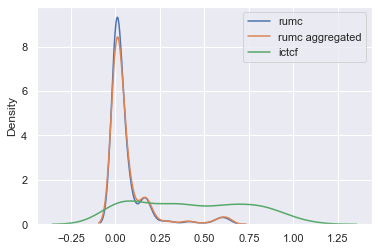

In [76]:
sns.kdeplot((~df_rumc.isna()).mean(), label='rumc')
sns.kdeplot((~df_rumc_aggr.isna()).mean(), label='rumc aggregated')
sns.kdeplot((~df_ictcf.isna()).mean(), label='ictcf')
plt.legend();

In [80]:
df_ictcf

,Value_5NT,Value_AFU,Value_ALB,Value_ALG,Value_ALP,Value_ALT,Value_APOA1,Value_APOB,Value_APTT,Value_ASO,...,Value_TT,Value_U,Value_UALB,Value_UNCC,Value_UNCX,Value_URBC,Value_URIC,Value_UWBC,Value_WBC,Value_WBCC
0,0.6,NaN,-0.015,-0.6,0.109091,1.657143,NaN,NaN,0.677419,NaN,...,0.457143,NaN,NaN,NaN,NaN,NaN,0.299091,NaN,-0.180000,NaN
1,0.9,NaN,0.295,0.2,-0.036364,1.285714,NaN,NaN,1.012903,NaN,...,0.642857,NaN,NaN,NaN,NaN,NaN,0.610455,NaN,-0.258333,NaN
2,NaN,NaN,-0.250,-1.2,0.036364,1.542857,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.402727,NaN,0.085000,NaN
3,0.8,NaN,-0.165,-0.6,0.236364,0.857143,NaN,NaN,0.696774,NaN,...,0.728571,NaN,NaN,NaN,NaN,NaN,0.155909,NaN,0.291667,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.635000,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1516,0.9,NaN,-0.045,-0.8,0.172727,2.600000,NaN,NaN,0.935484,NaN,...,0.785714,NaN,NaN,NaN,NaN,NaN,-0.049545,NaN,0.120000,NaN
1517,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.425000,NaN
1518,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.086667,NaN
1519,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.278333,NaN


In [110]:
df_rumc.loc[:, df_rumc.columns.str.lower().str.contains('glucose')]

Glucose  Glucose (Liquor)  Glucose (POCT)  \
patientprimarymrn study                                              
10000             st000      5.3               NaN             NaN   
                  st001      5.3               NaN             NaN   
10001             st000      NaN               NaN             NaN   
10002             st000      6.4               NaN             NaN   
10003             st000      NaN               NaN             NaN   
...                          ...               ...             ...   
10723             st000      NaN               NaN             NaN   
10724             st000      NaN               NaN             NaN   
10725             st000      NaN               NaN             NaN   
10726             st000      NaN               NaN             NaN   
10727             st000      NaN               NaN             NaN   

                         Glucose (bloedgas)  Glucose (overig)  \
patientprimarymrn study                                         
10000             st000                 4.2               NaN   
                  st001                 4.3               NaN   
10001             st000                 NaN               NaN   
10002             st000                 5.1               NaN   
10003             st000                 NaN               NaN   
...                                     ...               ...   
10723             st000                 NaN               NaN   
10724             st000                 NaN               NaN   
10725             st000                 NaN               NaN   
10726             st000                 NaN               NaN   
10727             st000                 NaN               NaN   

                         Glucose (urine)  Glucose T1  Glucose T1 (Bloedgas)  \
patientprimarymrn study                                                       
10000             st000              NaN         NaN                    NaN   
                  st001              NaN         NaN                    NaN   
10001             st000              NaN         NaN                    NaN   
10002             st000              NaN         NaN                    NaN   
10003             st000              NaN         NaN                    NaN   
...                                  ...         ...                    ...   
10723             st000              NaN         NaN                    NaN   
10724             st000              NaN         NaN                    NaN   
10725             st000              NaN         NaN                    NaN   
10726             st000              NaN         NaN                    NaN   
10727             st000              NaN         NaN                    NaN   

                         Glucose T2  Glucose T3  Glucose T4  \
patientprimarymrn study                                       
10000             st000         NaN         NaN         NaN   
                  st001         NaN         NaN         NaN   
10001             st000         NaN         NaN         NaN   
10002             st000         NaN         NaN         NaN   
10003             st000         NaN         NaN         NaN   
...                             ...         ...         ...   
10723             st000         NaN         NaN         NaN   
10724             st000         NaN         NaN         NaN   
10725             st000         NaN         NaN         NaN   
10726             st000         NaN         NaN         NaN   
10727             st000         NaN         NaN         NaN   

                        Glucose kwal. (Urine)  Glucose ratio liquor/bloed  
patientprimarymrn study                                                    
10000             st000              Negatief                         NaN  
                  st001              Negatief                         NaN  
10001             st000                   NaN                         NaN  
10002             st000                 

c:\users\roel\.virtualenvs\diagcovid-ckc2berq\lib\site-packages\seaborn\distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


<AxesSubplot:xlabel='Glucose', ylabel='Density'>

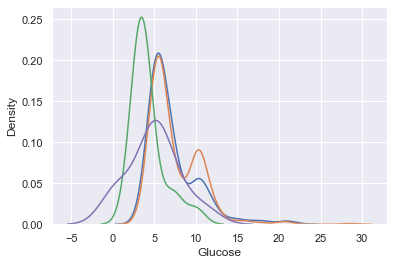

In [114]:
sns.kdeplot(df_rumc['Glucose'])
sns.kdeplot(df_rumc['Glucose (bloedgas)'])
sns.kdeplot(df_rumc['Glucose (Liquor)'])
sns.kdeplot(df_rumc['Glucose (urine)'])
sns.kdeplot(df_rumc['Glucose (overig)'])

In [120]:
df_rumc.columns[df_rumc.columns.str.match(r'.+?\s+\(.+?\)')]

Index(['% CD4+ T-Lymfocyten (CD3+CD4+)', '% CD8+ T-Lymfocyten (CD3+CD8+)',
       '% T-lymfocyten (CD3+)', '5-HIAA/MMOL KREAT (24uurs Urine)',
       '6-MMPR (Azathioprine/Mercaptopurine)',
       '6-MMPR-R (AZATHIOPRINE/MERCAPTOPURINE)',
       '6-TGN (Azathioprine/Mercaptopurine)',
       '6-TGN-R (AZATHIOPRINE/MERCAPTOPURINE)', 'ALAT (overig)',
       'ASAT (overig)',
       ...
       'hCG + hCGbeta (direct) in urine', 'hCG+hCGß (RIA, Mola) (HCG)',
       'hCG+hCGß (direct)', 'leukocyten (Urine)',
       'ongefract.Heparine (anti-Xa)', 'pH (POCT)', 'pH (Urine)',
       'pH (bloedgas)', 'pH (overig)', 'zuurstofsaturatie (POCT)'],
      dtype='object', length=479)

In [136]:
df_rumc_merged = df_rumc.copy()
df_rumc_merged.columns = df_rumc.columns.str.replace(r'\(.+?\)', '', regex=True).str.strip()

In [142]:
df_rumc_merged.columns[df_rumc_merged.columns.duplicated()].unique()

Index(['Pelger Huet', 'A'', 'ALAT', 'ASAT', 'AVA', 'AVA-I', 'Albumine',
       'Albumine nefelometrisch', 'Alfa-1-antitrypsine', 'Algemene kweek',
       ...
       'SV', 'Transferrine', 'Triglyceriden', 'Tuberculose kweek', 'Uraat',
       'Ureum', 'VZV IgG', 'Vrije kappa immunoblot', 'hCG+hCGß', 'pH'],
      dtype='object', length=115)

In [160]:
from pandas.api.types import is_numeric_dtype
def aggregate(x: pd.Series):
    if is_numeric_dtype(x.dtypes[0]):
        return x.mean(axis=1)
    return x.apply(lambda y: y[y.first_valid_index()] if y.first_valid_index() is not None else np.nan, axis=1)
#     return x.mode(axis=1)
df_rumc_merged2 = df_rumc_merged.groupby(df_rumc_merged.columns, axis=1).agg(aggregate)

In [161]:
df_rumc_merged2

% CD4+ T-Lymfocyten  % CD8+ T-Lymfocyten  \
patientprimarymrn study                                             
10000             st000                  NaN                  NaN   
                  st001                  NaN                  NaN   
10001             st000                  NaN                  NaN   
10002             st000                  NaN                  NaN   
10003             st000                  NaN                  NaN   
...                                      ...                  ...   
10723             st000                  NaN                  NaN   
10724             st000                  NaN                  NaN   
10725             st000                  NaN                  NaN   
10726             st000                  NaN                  NaN   
10727             st000                  NaN                  NaN   

                         % T-lymfocyten  3-Methoxytyramine  5-HIAA/MMOL KREAT  \
patientprimarymrn study                                                         
10000             st000             NaN                NaN                NaN   
                  st001             NaN                NaN                NaN   
10001             st000             NaN                NaN                NaN   
10002             st000             NaN                NaN                NaN   
10003             st000             NaN                NaN                NaN   
...                                 ...                ...                ...   
10723             st000             NaN                NaN                NaN   
10724             st000             NaN                NaN                NaN   
10725             st000             NaN                NaN                NaN   
10726             st000             NaN                NaN                NaN   
10727             st000             NaN                NaN                NaN   

                         6-MMPR  6-MMPR-R  6-TGN  6-TGN-R  A Dur  ...  \
patientprimarymrn study                                           ...   
10000             st000     NaN       NaN    NaN      NaN    NaN  ...   
                  st001     NaN       NaN    NaN      NaN    NaN  ...   
10001             st000     NaN       NaN    NaN      NaN    NaN  ...   
10002             st000     NaN       NaN    NaN      NaN    NaN  ...   
10003             st000     NaN       NaN    NaN      NaN    NaN  ...   
...                         ...       ...    ...      ...    ...  ...   
10723             st000     NaN       NaN    NaN      NaN    NaN  ...   
10724             st000     NaN       NaN    NaN      NaN    NaN  ...   
10725             st000     NaN       NaN    NaN      NaN    NaN  ...   
10726             st000     NaN       NaN    NaN      NaN    NaN  ...   
10727             st000     NaN       NaN    NaN      NaN    NaN  ...   

                         para-Influenzavirus 1 Ig  para-Influenzavirus 2 Ig  \
patientprimarymrn study                                                       
10000             st000                       NaN                       NaN   
                  st001                       NaN                       NaN   
10001             st000                       NaN                       NaN   
10002             st000                       NaN                       NaN   
10003             st000                       NaN                       NaN   
...                                           ...                       ...   
10723             st000                       NaN                       NaN   
10724             st000                       NaN                       NaN   
10725             st000                       NaN                       NaN   
10726             st000                       NaN                       NaN   
10727             st000                       NaN                       NaN   

                        para-Influenzavirus 3 Ig  plasmacytoide lymfocyten  \
patientprimarymrn

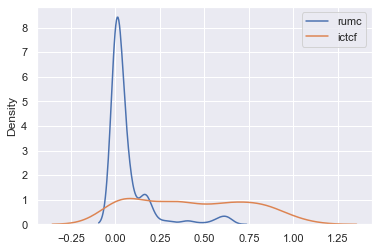

In [162]:
sns.kdeplot((~df_rumc_merged2.isna()).mean(), label='rumc')
sns.kdeplot((~df_ictcf.isna()).mean(), label='ictcf')
plt.legend();

In [163]:
import matplotlib.pyplot as plt
xs = np.linspace(0.2, 1, 100)
y_rumc = [((~df_rumc_merged2.isna()).mean() > x).sum() for x in xs]
y_ictcf = [((~df_ictcf.isna()).mean() > x).sum() for x in xs]

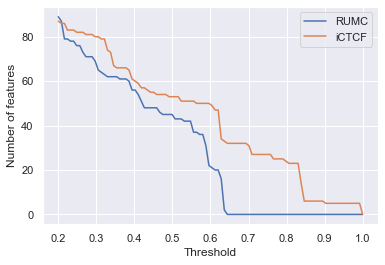

In [164]:
sns.set()
plt.plot(xs, y_rumc, label='RUMC')
plt.plot(xs, y_ictcf, label='iCTCF')
plt.xlabel('Threshold')
plt.ylabel('Number of features')
plt.legend()

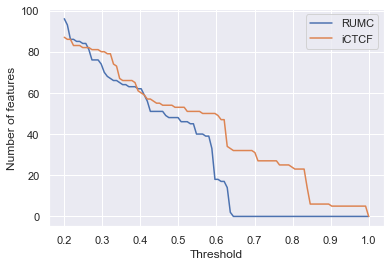

In [97]:
sns.set()
plt.plot(xs, y_rumc, label='RUMC')
plt.plot(xs, y_ictcf, label='iCTCF')
plt.xlabel('Threshold')
plt.ylabel('Number of features')
plt.legend()

In [146]:
pd.Series([np.nan]).mean()

nan

In [154]:
for g in df_rumc_merged.groupby(df_rumc_merged.columns, axis=1):
    print(g)
    error()

('% CD4+ T-Lymfocyten',                          % CD4+ T-Lymfocyten
patientprimarymrn study                     
10000             st000                  NaN
                  st001                  NaN
10001             st000                  NaN
10002             st000                  NaN
10003             st000                  NaN
...                                      ...
10723             st000                  NaN
10724             st000                  NaN
10725             st000                  NaN
10726             st000                  NaN
10727             st000                  NaN

[814 rows x 1 columns])


NameError: name 'error' is not defined

In [157]:
g[1].apply(lambda x: x[x.first_valid_index()] if x.first_valid_index() is not None else np.nan, axis=1)

patientprimarymrn  study
10000              st000   NaN
                   st001   NaN
10001              st000   NaN
10002              st000   NaN
10003              st000   NaN
                            ..
10723              st000   NaN
10724              st000   NaN
10725              st000   NaN
10726              st000   NaN
10727              st000   NaN
Length: 814, dtype: float64